OBJECTIVE

To use cloud cover over a specific geographical area to generate a Random set of values.



WEB SCRAPPER

Using Selenium to aoutmate chrome allowing for the download of satelite imagery from meteoblue.com. This images are updated every 15 minuites. As a result only 1 set of random numbers ca be generated every 15 minutes. 

In [33]:


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import os


def wait_for_download(download_dir, timeout=30):
    start_time = time.time()
    while time.time() - start_time < timeout:
        files = os.listdir(download_dir)
        if any(file.endswith(".crdownload") for file in files):
            time.sleep(1)  # Wait for ongoing downloads to finish
        else:
            # Return the most recently downloaded file
            return max(
                [os.path.join(download_dir, f) for f in files],
                key=os.path.getctime
            )
    raise TimeoutError("Download did not complete within the given time.")


# Define your custom download directory
download_dir = "/Users/wamaka/Desktop/PROJECTS/web scrapping/downloads"

# Ensure the directory exists
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Set up Chrome options
chrome_options = Options()
chrome_options.add_experimental_option("prefs", {
    "download.default_directory": download_dir,  # Custom download directory
    "download.prompt_for_download": False,      # Disable download prompt
    "download.directory_upgrade": True,         # Allow directory upgrade for automatic downloads
    "safebrowsing.enabled": True                # Enable safe browsing
})

# Initialize WebDriver
PATH = "/Users/wamaka/Desktop/PROJECTS/web scrapping/chromedriver copy"
service = Service(PATH)
wd = webdriver.Chrome(service=service, options=chrome_options)

url = "https://www.meteoblue.com/en/country/weather/satellite/south-africa_south-africa_953987"

try:
    # Open the target URL
    wd.get(url)

    # Accept cookies
    button1 = WebDriverWait(wd, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "fc-primary-button"))
    )
    button1.click()
    print("Accepted cookies.")

    # Debugging delay to allow the page to fully load
    time.sleep(2)

    # Click the "Screenshot" button
    button2 = WebDriverWait(wd, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//a[text()='Screenshot']"))
    )
    button2.click()
    print("Clicked the Screenshot button.")

    # Debugging delay to allow the download to start
    time.sleep(5)

    # Wait for the file to download
    downloaded_file = wait_for_download(download_dir, timeout=30)
    print(f"Downloaded file: {downloaded_file}")

except Exception as e:
    print("An error occurred:", e)

finally:
    # Close the browser
    wd.quit()


Accepted cookies.
Clicked the Screenshot button.
Downloaded file: /Users/wamaka/Desktop/PROJECTS/web scrapping/downloads/Satellite-No-Radar_20250124T123000+0200.jpeg


seed calculator


Here, Numpy and Matplotlib are used to visualise and quanitfy cloud cover.

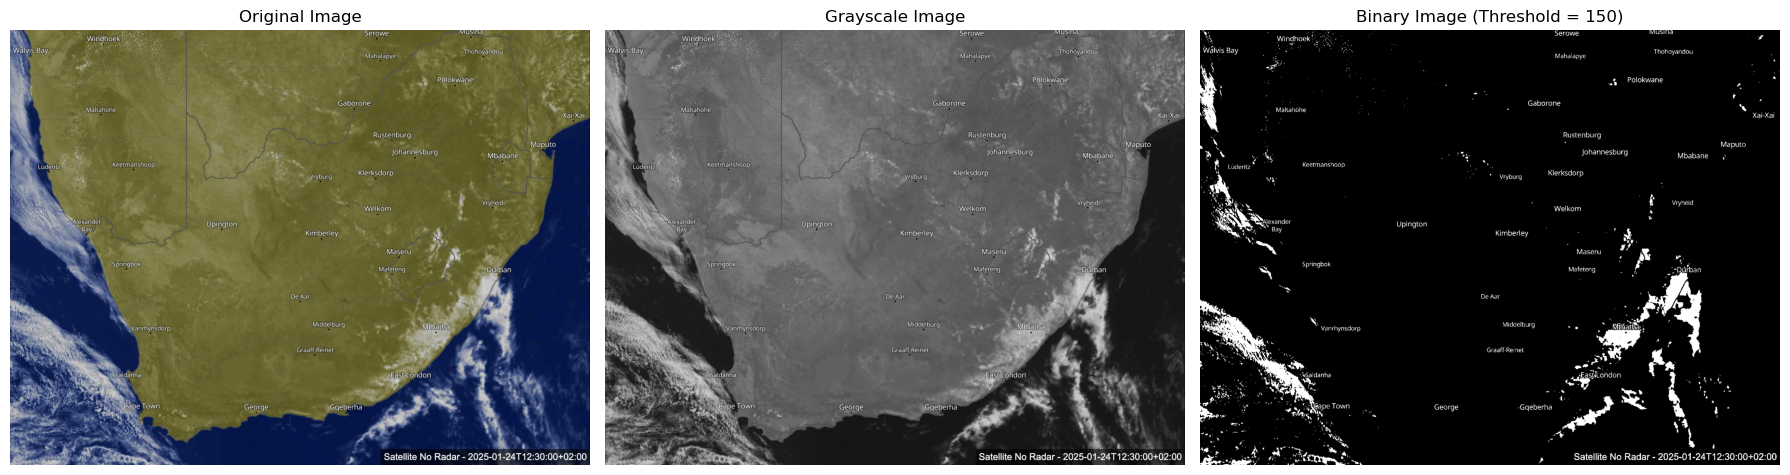

Most Recent Image: /Users/wamaka/Desktop/PROJECTS/web scrapping/downloads/Satellite-No-Radar_20250124T123000+0200.jpeg
Cloud Cover Percentage: 4.5885%


In [34]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Specify the folder containing the images
folder_path = "/Users/wamaka/Desktop/PROJECTS/web scrapping/downloads"  # Replace with your folder path

# Get the most recent image file in the folder
image_files = glob.glob(os.path.join(folder_path, "*.jpeg"))  # Adjust extension if necessary
if not image_files:
    raise FileNotFoundError("No image files found in the specified folder.")
most_recent_image = max(image_files, key=os.path.getmtime)

# Load the most recent image
image = Image.open(most_recent_image)

# Convert image to grayscale
gray_image = image.convert("L")

# Convert grayscale image to a NumPy array
gray_array = np.array(gray_image)

# Set the chosen threshold to 150
chosen_threshold = 150

# Create binary image using the chosen threshold
binary_image_150 = (gray_array > chosen_threshold).astype(int)

# Calculate cloud cover percentage to 4 decimal places
cloud_pixels_150 = np.sum(binary_image_150)
total_pixels = binary_image_150.size
cloud_cover_percentage_150 = round((cloud_pixels_150 / total_pixels) * 100, 4)

# Plot the original, grayscale, and binary images
plt.figure(figsize=(18, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

# Grayscale Image
plt.subplot(1, 3, 2)
plt.title("Grayscale Image")
plt.imshow(gray_image, cmap="gray")
plt.axis("off")

# Binary Image (Threshold = 150)
plt.subplot(1, 3, 3)
plt.title("Binary Image (Threshold = 150)")
plt.imshow(binary_image_150, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# Output the cloud cover percentage
print(f"Most Recent Image: {most_recent_image}")
print(f"Cloud Cover Percentage: {cloud_cover_percentage_150}%")


NUMBER GENERATOR

This combines the cloud generated values with hardware-sources randomness to generate a final random set of numbers. 

In [35]:
# Read true random bytes from /dev/random
with open("/dev/random", "rb") as f:
    true_random_bytes = f.read(10)  # Read 10 random bytes

# Convert bytes to integers and combine with cloud cover
cloud_cover_percentage = 4.8612
true_random_numbers = [int(byte) + int(cloud_cover_percentage * 100) for byte in true_random_bytes]

print("True Random Numbers:", true_random_numbers)


True Random Numbers: [624, 737, 563, 591, 652, 724, 634, 623, 723, 711]


Test for randomness 

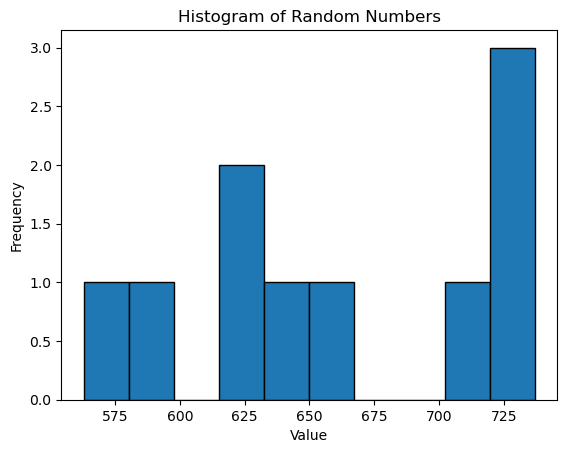

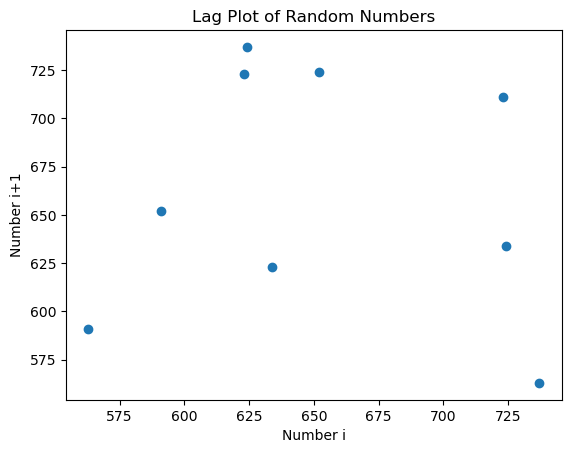

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example random numbers
random_numbers = true_random_numbers

# Histogram
plt.hist(random_numbers, bins=10, edgecolor="black")
plt.title("Histogram of Random Numbers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Lag plot
plt.scatter(random_numbers[:-1], random_numbers[1:])
plt.title("Lag Plot of Random Numbers")
plt.xlabel("Number i")
plt.ylabel("Number i+1")
plt.show()


In [38]:
import numpy as np
from scipy.stats import chisquare

# Function to perform Chi-Square test on a dynamic dataset
def perform_chi_square_test(random_numbers):
    # Automatically calculate the bins based on the range of the numbers
    min_val, max_val = min(random_numbers), max(random_numbers)
    num_bins = 5  # You can adjust this to change the number of bins
    bins = np.linspace(min_val, max_val, num_bins + 1)
    
    # Bin the random numbers into intervals
    observed, _ = np.histogram(random_numbers, bins=bins)

    # Expected frequency for uniform distribution (based on the number of intervals)
    expected = [len(random_numbers) / (num_bins)] * num_bins

    # Perform the Chi-Square test
    chi_stat, p_value = chisquare(observed, expected)

    # Output results
    print(f"Chi-Square Statistic: {chi_stat}")
    print(f"P-Value: {p_value}")

    if p_value > 0.05:
        print("The sequence appears random (fail to reject null hypothesis).")
    else:
        print("The sequence does not appear random (reject null hypothesis).")


perform_chi_square_test(random_numbers)


Chi-Square Statistic: 7.0
P-Value: 0.13588822540043327
The sequence appears random (fail to reject null hypothesis).
